In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random, time
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CFG = dict(
    csv_path   = '../data/data.csv',
    target_col  = "load_mw",
    save_name   = "../checkpoints/aedl.pt",  # where to save the model weights

    # ------------- model / trainer settings  -------------
    past_len    = 48,  
    pred_len    = 24,     
    batch_size  = 256,
    hidden_size = 128,
    num_layers  = 2,
    attn_heads  = 8,
    dropout     = 0.1,
    lr          = 2e-4,
    epochs      = 50,
    train_pct   = 0.8,
    val_pct     = 0.2,
    es_patience = 30,


    # exogenous vars
    weather_cols = [
        "temperature",
        "dewpoint",
        "pressure_nn",
        "windspeed",
    ],
    known_future_cols = "temperature_forecast",    

    train_intervals = [("2014-09-02", "2021-12-31 23:00")],
    test_intervals  = [("2022-01-01", "2022-02-28 23:00")],
)

cpu


In [2]:

# read & tidy ----------------------------------------------------
raw_df = (
    pd.read_csv(
        CFG["csv_path"],
        sep=",",
        parse_dates=["MESS_DATUM"],   # <— time stamp column
        dayfirst=False,               # flip if your dates are DD-MM-YYYY
        index_col=0
    )
    .rename(columns=str.lower)        # optional: unify lower-case names
)

# give the timestamp an unmistakable name and make it the index
raw_df = raw_df.rename(columns={"mess_datum": "timestamp"}).set_index("timestamp").sort_index()

# cyclic time encodings --------------------------------------------------------
_dt  = raw_df.index
hour = _dt.hour + _dt.minute/60
raw_df["h_sin"], raw_df["h_cos"] = np.sin(2*np.pi*hour/24), np.cos(2*np.pi*hour/24)

dow = _dt.dayofweek
raw_df["dow_sin"], raw_df["dow_cos"] = np.sin(2*np.pi*dow/7), np.cos(2*np.pi*dow/7)

moy = _dt.month - 1
raw_df["moy_sin"], raw_df["moy_cos"] = np.sin(2*np.pi*moy/12), np.cos(2*np.pi*moy/12)

df = raw_df#[[CFG["target_col"], *CFG["weather_cols"],
            #"h_sin", "h_cos", "dow_sin", "dow_cos", "moy_sin", "moy_cos"]].dropna()


In [3]:

# %% ───────────────────────────── chronological splits ─────────────────────────
train_df = pd.concat([df.loc[a:b] for a, b in CFG["train_intervals"]])
val_df   = train_df.iloc[int(CFG['train_pct']*len(train_df)):]   # last 20 %
train_df_temp = train_df.iloc[:int(CFG['train_pct']*len(train_df))]

test_df  = pd.concat([df.loc[a:b] for a, b in CFG["test_intervals"]])
ctx_start = train_df.index[-CFG["past_len"]]

# full span incl. context right before test start
ctx_df = df.loc[ctx_start : test_df.index[-1]]

# %% ─────────────────────────────── normalisers --------------------------------
scaler_x = StandardScaler().fit(train_df.values)  # all features except target fix ↓
scaler_y = StandardScaler().fit(train_df[[CFG["target_col"]]])

# %% ───────────────────────── dataset with correct scaling ---------------------
class SlidingWindowDS(Dataset):
    """Return (past_feats, future_temp, target) each standardised consistently."""
    def __init__(self, data: pd.DataFrame, past: int, horizon: int,
                 scaler_x: StandardScaler, scaler_y: StandardScaler,
                 target_col: str, exog_col: str = "temperature_forecast"):

        self.cols      = list(data.columns)
        self.tgt_idx   = self.cols.index(target_col)
        self.exog_idx  = self.cols.index(exog_col)
        self.past_len  = past
        self.horizon   = horizon

        # ---------- scale ---------------------------------------------------
        arr = scaler_x.transform(data.values.astype(np.float32))
        # re‑scale the *target* column with scaler_y (target‑only stats)
        arr[:, self.tgt_idx] = scaler_y.transform(
            data.iloc[:, self.tgt_idx].values.reshape(-1, 1)).ravel()
        self.arr = arr

    def __len__(self):
        return len(self.arr) - self.past_len - self.horizon + 1

    def __getitem__(self, idx):
        p = self.past_len; h = self.horizon
        past   = self.arr[idx : idx+p]                                   # (p,F)
        futtmp = self.arr[idx+p : idx+p+h, self.exog_idx]                # (h,)
        target = self.arr[idx+p : idx+p+h, self.tgt_idx].reshape(-1, 1)  # (h,1)
        return (torch.from_numpy(past),
                torch.from_numpy(futtmp).unsqueeze(-1),
                torch.from_numpy(target))

# datasets & loaders -----------------------------------------------------------
tr_ds = SlidingWindowDS(train_df, CFG["past_len"], CFG["pred_len"],
                        scaler_x, scaler_y, CFG["target_col"],
                        exog_col=CFG["known_future_cols"])
va_ds = SlidingWindowDS(val_df,   CFG["past_len"], CFG["pred_len"],
                        scaler_x, scaler_y, CFG["target_col"],
                        exog_col=CFG["known_future_cols"])
test_ds = SlidingWindowDS(ctx_df, CFG["past_len"], CFG["pred_len"],
                          scaler_x, scaler_y, CFG["target_col"],
                          exog_col=CFG["known_future_cols"])

# limit windows to those whose horizon lies fully inside true test span
first = CFG["past_len"]
last  = len(ctx_df) - CFG["pred_len"]
valid_idx = range(first, last+1)

test_ds.indices = valid_idx  # attribute used below

def _dl(ds):
    return DataLoader(ds, batch_size=CFG["batch_size"], shuffle=isinstance(ds, type(tr_ds)))

tr_ld, va_ld, test_ld = map(_dl, (tr_ds, va_ds, test_ds))


/opt/miniconda3/envs/ai4hp/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/ai4hp/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/ai4hp/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:

# %% ───────────────────────────── model architecture --------------------------
class TemporalSelfAttention(nn.Module):
    def __init__(self, hidden: int, heads: int, drop: float):
        super().__init__()
        self.mha  = nn.MultiheadAttention(hidden, heads, dropout=drop, batch_first=True)
        self.norm = nn.LayerNorm(hidden)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        y, _ = self.mha(x, x, x)
        return self.norm(x + self.drop(y))

class AEDL(nn.Module):
    def __init__(self, n_feat: int, hidden: int, layers: int, heads: int,
                 drop: float, horizon: int, tgt_idx: int):
        super().__init__()
        self.horizon  = horizon
        self.tgt_idx  = tgt_idx
        self.encoder  = nn.LSTM(n_feat, hidden, layers, batch_first=True, dropout=drop)
        self.attn     = TemporalSelfAttention(hidden, heads, drop)
        self.decoder  = nn.LSTM(2, hidden, layers, batch_first=True, dropout=drop)
        self.to_load  = nn.Linear(hidden, 1)

    def forward(self, x: Tuple[torch.Tensor, torch.Tensor]):
        past, fut = x                 # past:(B,p,F)  fut:(B,h,1)
        _, (h, c) = self.encoder(past)
        y_prev = past[:, -1:, self.tgt_idx:self.tgt_idx+1]
        outs = []
        for t in range(self.horizon):
            dec_in = torch.cat([y_prev, fut[:, t:t+1]], dim=-1)  # (B,1,2)
            dec_out, (h, c) = self.decoder(dec_in, (h, c))
            y_hat = self.to_load(dec_out)
            outs.append(y_hat)
            y_prev = y_hat                     # teacher‑forcing off
        return torch.cat(outs, dim=1).squeeze(-1)  # (B,h)

# model / optim ---------------------------------------------------------------
feat_cnt  = len(df.columns)
tgt_idx   = df.columns.get_loc(CFG["target_col"])
model     = AEDL(feat_cnt, CFG["hidden_size"], CFG["num_layers"],
                 CFG["attn_heads"], CFG["dropout"], CFG["pred_len"], tgt_idx).to(device)
loss_fn   = nn.L1Loss()
opt       = torch.optim.AdamW(model.parameters(), lr=CFG["lr"])

# %% ───────────────────────────────── helpers ----------------------------------
@torch.no_grad()
def inverse_scale(arr):
    flat = arr.reshape(-1, 1)
    return scaler_y.inverse_transform(flat).reshape(arr.shape)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    abs_sum = pct_sum = 0.0
    sum_targets = 0.0
    n_abs = n_pct = n_tgt = 0

    for past, fut, tgt in loader:
        past, fut = past.to(device), fut.to(device)
        pred = model((past, fut)).cpu().numpy()
        tgt  = tgt.squeeze(-1).numpy()

        pred = inverse_scale(pred)
        tgt  = inverse_scale(tgt)

        # accumulate errors
        abs_sum += np.abs(pred - tgt).sum()
        n_abs   += pred.size

        # accumulate percentage error
        mask     = tgt > 0.1
        pct_sum += (np.abs(pred - tgt)[mask] / np.abs(tgt[mask])).sum()
        n_pct   += mask.sum()

        # accumulate for NMAE denominator
        sum_targets += tgt.sum()
        n_tgt       += tgt.size

    mae  = abs_sum / n_abs
    mape = 100 * pct_sum / n_pct
    global_mean = sum_targets / n_tgt
    nmae = mae / global_mean * 100
    return mae, mape, nmae

In [5]:

# %% ───────────────────────────────── training ---------------------------------
best, wait = float("inf"), 0

print("→ Training …");
total_t = time.time()

for epoch in range(1, CFG["epochs"] + 1):
    model.train(); running = 0.0
    for past, fut, tgt in tr_ld:
        past, fut = past.to(device), fut.to(device)
        tgt = tgt.to(device).squeeze(-1)
        opt.zero_grad(); pred = model((past, fut))
        loss = loss_fn(pred, tgt); loss.backward(); opt.step()
        running += loss.item() * past.size(0)
    tr_mae_std = running / len(tr_ld.dataset)

    val_mae, val_mape, _ = evaluate(va_ld)
    if val_mae < best - 0.1:
        best, wait = val_mae, 0
        torch.save(model.state_dict(), CFG["save_name"])
    else:
        wait += 1
        if wait >= CFG["es_patience"]:
            print(f"✋ Early stop after epoch {epoch}"); break

    print(f"Ep {epoch:02d} | train(MAE*std) {tr_mae_std:.4f} | "
          f"val MAE {val_mae:,.2f} kW | MAPE {val_mape:,.2f} % | wait {wait}/{CFG['es_patience']}")

    print(f"Training time: {(time.time()-total_t)/60:.2f} min")


→ Training …
10.754165464806269
Ep 01 | train(MAE*std) 0.0246 | val MAE 3.00 kW | MAPE 12.99 % | wait 0/30
Training time: 2.36 min
10.754165464806269
Ep 02 | train(MAE*std) 0.0191 | val MAE 2.83 kW | MAPE 10.92 % | wait 0/30
Training time: 4.82 min
10.754165490269413
Ep 03 | train(MAE*std) 0.0174 | val MAE 2.66 kW | MAPE 9.21 % | wait 0/30
Training time: 6.39 min
10.75416547753784
Ep 04 | train(MAE*std) 0.0158 | val MAE 2.55 kW | MAPE 8.14 % | wait 0/30
Training time: 7.21 min
10.754165452074696
Ep 05 | train(MAE*std) 0.0152 | val MAE 2.53 kW | MAPE 7.61 % | wait 1/30
Training time: 8.05 min
10.754165553927272
Ep 06 | train(MAE*std) 0.0148 | val MAE 2.54 kW | MAPE 8.28 % | wait 2/30
Training time: 8.87 min
10.75416559212199
Ep 07 | train(MAE*std) 0.0146 | val MAE 2.49 kW | MAPE 7.11 % | wait 3/30
Training time: 9.79 min
10.754165566658845
Ep 08 | train(MAE*std) 0.0144 | val MAE 2.46 kW | MAPE 6.77 % | wait 4/30
Training time: 10.71 min
10.754165362953692
Ep 09 | train(MAE*std) 0.0144 |

26.843486405240487
TEST MAE  : 13.28 MW
TEST MAPE : 5.97 %
{'csv_path': '../data/data.csv', 'target_col': 'load_mw', 'save_name': '../checkpoints/aedl.pt', 'past_len': 48, 'pred_len': 24, 'batch_size': 256, 'hidden_size': 128, 'num_layers': 2, 'attn_heads': 8, 'dropout': 0.1, 'lr': 0.0002, 'epochs': 50, 'train_pct': 0.8, 'val_pct': 0.2, 'es_patience': 30, 'weather_cols': ['temperature', 'dewpoint', 'pressure_nn', 'windspeed'], 'known_future_cols': 'temperature_forecast', 'train_intervals': [('2014-09-02', '2021-12-31 23:00')], 'test_intervals': [('2022-01-01', '2022-02-28 23:00')]}


/var/folders/2f/70bdv72s5tx7tbn3b58m5xfw0000gn/T/ipykernel_1717/1770747004.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rng = pd.date_range(ts0, periods=CFG["pred_len"], freq="H")


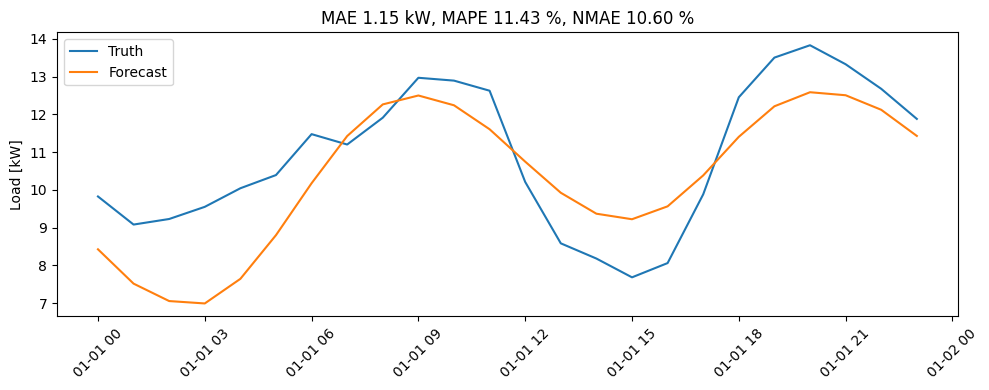

In [6]:
torch.save(model.state_dict(), CFG["save_name"])
# %% ─────────────────────────────── testing & plot -----------------------------
model.load_state_dict(torch.load(CFG["save_name"]))
model.eval()

t_mae, t_mape, t_nmae = evaluate(test_ld)
print(f"TEST MAE  : {t_mae:,.2f} MW\nTEST MAPE : {t_mape:,.2f} %") #\nTEST NMAE : {t_nmae:,.2f} %")
print(CFG)

@torch.no_grad()
def plot_sample(idx: int = 0):
    past, fut, tgt = test_ds[idx]
    ts0 = pd.to_datetime(CFG["test_intervals"][0][0]) + pd.Timedelta(hours=idx)
    pred = model((past.unsqueeze(0).to(device), fut.unsqueeze(0).to(device))).cpu().numpy()[0]
    tgt  = tgt.squeeze(-1).numpy()
    pred_kW, tgt_kW = inverse_scale(pred), inverse_scale(tgt)
    rng = pd.date_range(ts0, periods=CFG["pred_len"], freq="H")

    mask = tgt_kW != 0
    mape = 100 * (np.abs(pred_kW - tgt_kW)[mask] / np.abs(tgt_kW[mask])).sum()/ mask.sum()
    mae = np.abs(pred_kW - tgt_kW).mean()
    nmae = mae / tgt_kW.mean()*100  # normalized MAE

    plt.figure(figsize=(10,4))
    plt.plot(rng, tgt_kW, label="Truth")
    plt.plot(rng, pred_kW, label="Forecast")
    plt.title(f"MAE {mae:,.2f} kW, MAPE {mape:,.2f} %, NMAE {nmae:,.2f} %")
    plt.xticks(rotation=45); plt.ylabel("Load [kW]")
    plt.legend(); plt.tight_layout(); plt.show()

# quick visual
plot_sample(0)
